In [120]:
import obspy 
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from tqdm import tqdm
import os
import time
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score
from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters, MinimalFCParameters
import time

In [123]:
iq_lats = pd.read_csv('icequakes_catalog.csv')['latitude']
iq_lons = pd.read_csv('icequakes_catalog.csv')['longitude']

eq_lats = pd.read_csv('earthquakes_catalog.csv')['latitude']
eq_lons = pd.read_csv('earthquakes_catalog.csv')['longitude']

stns = pd.read_csv('gmap-stations.txt', sep='|', skiprows=[2,6])


stations = stns.values[:,1].astype('str')
stn_lats = stns.values[:,2].astype('float')
stn_lons = stns.values[:,3].astype('float')
gl_lat, gl_lon = 61.219722, -146.895278

In [5]:
stns = pd.read_csv('gmap-stations.txt', sep='|', skiprows=[2,6])
stns

,#Network,Station,Latitude,Longitude,Elevation,Sitename,StartTime,EndTime
0,AK,BAE,61.131900,-148.123400,578.0,"Barry Arm East, AK, USA",2020-09-04T00:00:00,2599-12-31T23:59:59
1,AK,BAT,61.141600,-148.175100,1027.0,"Barry Arm Top, AK, USA",2021-07-23T00:00:00,2599-12-31T23:59:59
2,AK,BAW,61.150100,-148.150100,542.0,"Barry Arm West, AK, USA",2020-09-04T00:00:00,2021-04-30T23:59:59
3,AK,EYAK,60.548698,-145.750000,133.9,"Cordova Ski Area, AK, USA",2002-10-03T00:00:00,2599-12-31T23:59:59
4,AK,FID,60.727699,-146.598694,500.0,"Fidalgo, AK, USA",2010-07-26T00:00:00,2599-12-31T23:59:59
5,AK,GLI,60.879200,-147.095901,430.0,"Glacier Island, AK, USA",2010-07-26T00:00:00,2599-12-31T23:59:59
6,AK,HIN,60.396000,-146.503494,622.9,"Hinchinbrook, AK, USA",2009-11-01T00:00:00,2599-12-31T23:59:59
7,AK,KLU,61.492400,-145.922700,1047.1,"Klutina Pass, AK, USA",2008-09-13T00:00:00,2599-12-31T23:59:59
8,AK,KNK,61.413100,-148.458500,598.0,"Knik Glacier, AK, USA",2010-06-13T00:00:00,2599-12-31T23:59:59
9,AK,M23K,61.792900,-147.726200,583.0,"Glacier View, AK, USA",2020-04-17T00:00:00,2599-12-31T23:59:59


In [201]:
def load_dataset_spectrum(station, l=0, freq_band = None):
    '''station = station name
    l = [0,1,2] for [E,N,Z]
    freq_band = filter band to apply'''
    
    start_time = time.time()
    X1 = []
    for i in range(len(glob('Data/icequake_waveforms/*'+station+'*'))):
        st = obspy.read(glob('Data/icequake_waveforms/*'+station+'*')[i])
        if freq_band:
            st.filter(type='bandpass', freqmin=freq_band[0], freqmax=freq_band[1])
        if len(np.abs(np.fft.fft(st[l].data))) == 15000:
            X1.append(np.abs(np.fft.fft(st[l].data))/np.max(np.abs(np.fft.fft(st[l].data))))    
            
    X2 = []
    for i in range(len(glob('Data/earthquake_waveforms/*'+station+'*'))):
        st = obspy.read(glob('Data/earthquake_waveforms/*'+station+'*')[i])
        if freq_band:
            st.filter(type='bandpass', freqmin=freq_band[0], freqmax=freq_band[1])
        if len(np.abs(np.fft.fft(st[l].data))) == 15000:
            X2.append(np.abs(np.fft.fft(st[l].data))/np.max(np.abs(np.fft.fft(st[l].data))))   
            
            
    X = X1 +X2
    X = np.array(X)
    a = np.ones(len(X1))
    b = np.zeros(len(X2))
    c = np.concatenate([a,b])
    y = c        
    
    end_time = time.time()
    print(end_time-start_time)

    return X,y

def forest_test(X, Y, n_estimators= 50):
    X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, 
                                                        test_size = 0.30, 
                                                        random_state = 101)
    #X_train_fs, X_test_fs, fs = select_features(X_Train, Y_Train, X_Test)
    
    start = time.process_time()
    trainedforest = RandomForestClassifier(n_estimators=n_estimators).fit(X_Train,Y_Train)
    dur = time.process_time() - start
    predictionforest = trainedforest.predict(X_Test)
    print(confusion_matrix(Y_Test,predictionforest))
    print(classification_report(Y_Test,predictionforest))
    acc = accuracy_score(Y_Test, predictionforest)
    
    return acc, dur

In [149]:
def load_dataset_tsfresh(station, l=0):
    X1 = []
    for i in range(len(glob('Data/icequake_waveforms/*'+station+'*'))):
        st = obspy.read(glob('Data/icequake_waveforms/*'+station+'*')[i])
        st.resample(10)
        if len(st[l].data) == 3000:
            X1.append(st[l].data)

    X2 = []
    for i in range(len(glob('Data/earthquake_waveforms/*'+station+'*'))):
        st = obspy.read(glob('Data/earthquake_waveforms/*'+station+'*')[i])
        st.resample(10)
        if len(st[l].data) == 3000:    
            X2.append(st[l].data)


    X = X1 +X2
    X = np.array(X)
    a = np.ones(len(X1))
    b = np.zeros(len(X2))
    c = np.concatenate([a,b])
    y = c 
    
    df = pd.DataFrame(X.transpose())
    df['time'] = st[0].times()
    df['id'] = np.zeros([np.shape(X)[1],1])
    df_features = extract_features(df,column_id = "id",column_sort="time", default_fc_parameters = EfficientFCParameters())    
    
    features = df_features.copy()
    new_features = pd.melt(features)
    Variables = new_features['variable'][0:783].values
    X_features = new_features['value'].values
    
    X_input = np.reshape(X_features, [np.shape(X)[0],783])
    
    return X_input,y

## Saving Features Extracted from Tsfresh

In [152]:
starttime = time.time()
for i in tqdm(range(len(stations))):
    X,y = load_dataset_tsfresh(stations[i], l=0)
    np.savetxt("/home/aakash/Desktop/Reference_Papers/Icequakes_Vs_Tectonicquakes/tsfresh_features/"+stations[i]+".txt", X)
    np.savetxt("/home/aakash/Desktop/Reference_Papers/Icequakes_Vs_Tectonicquakes/tsfresh_features/"+stations[i]+"_labels.txt", y)
endtime = time.time()

print("Total time taken:", endtime-starttime)    

Feature Extraction:   1%|█▊                                                                                                                                                 | 1/80 [00:33<43:58, 33.40s/it]


Feature Extraction:   7%|█████████▊                                                                                                                                         | 5/75 [00:29<03:50,  3.30s/it]


Feature Extraction:  18%|█████████████████████████▌                                                                                                                        | 14/80 [05:08<02:57,  2.69s/it]


Feature Extraction:  12%|██████████████████▎                                                                                                                               | 10/80 [03:30<03:50,  3.29s/it]


Feature Extraction:   8%|███████████                                                                                                                                        | 6/80 [04:32<21:40, 17.57s/it]


Feature Extraction:   6%|█████████▎                                                                                                                                         | 5/79 [04:21<30:48, 24.98s/it]


Feature Extraction:   4%|█████▍                                                                                                                                           | 3/80 [04:26<1:16:43, 59.78s/it]


 53%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 8/15 [2:26:57<2:50:46, 1463.74s/it]


Feature Extraction:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 78/80 [23:49<00:05,  2.85s/it]


Feature Extraction:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 76/79 [08:52<00:04,  1.38s/it]


Feature Extraction:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 76/80 [08:11<00:05,  1.41s/it]


Feature Extraction:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 73/79 [18:10<00:33,  5.59s/it]


Feature Extraction:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 71/80 [23:56<01:51, 12.44s/it]


Feature Extraction:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 68/80 [24:15<06:24, 32.08s/it]


Feature Extraction:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 66/80 [08:06<03:00, 12.89s/it]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [4:52:05<00:00, 1168.36s/it]

Total time taken: 17525.355109214783


### It took around 5 hours to extract 783 features from each of the waveform considered. 

### Extracting Absolute Frequency Spectrum as Features. 

In [202]:
starttime = time.time()
for i in tqdm(range(len(stations))):
    X,y = load_dataset_spectrum(stations[i], l=0)
    np.savetxt("/home/aakash/Desktop/Reference_Papers/Icequakes_Vs_Tectonicquakes/spectrum_features/"+stations[i]+".txt", X)
    np.savetxt("/home/aakash/Desktop/Reference_Papers/Icequakes_Vs_Tectonicquakes/spectrum_features/"+stations[i]+"_labels.txt", y)
endtime = time.time()

print("Total time taken:", endtime-starttime)

  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

40.46273756027222


  7%|███████████▏                                                                                                                                                           | 1/15 [00:52<12:21, 52.99s/it]

30.937475442886353


 13%|██████████████████████▎                                                                                                                                                | 2/15 [01:32<09:47, 45.21s/it]

19.36884355545044


 20%|█████████████████████████████████▍                                                                                                                                     | 3/15 [01:58<07:16, 36.37s/it]

226.75124597549438


 27%|████████████████████████████████████████████▎                                                                                                                         | 4/15 [06:55<25:30, 139.17s/it]

159.9049849510193


 33%|███████████████████████████████████████████████████████▎                                                                                                              | 5/15 [10:28<27:37, 165.73s/it]

210.75847840309143


 40%|██████████████████████████████████████████████████████████████████▍                                                                                                   | 6/15 [14:59<30:15, 201.75s/it]

203.30353212356567


 47%|█████████████████████████████████████████████████████████████████████████████▍                                                                                        | 7/15 [19:24<29:39, 222.41s/it]

208.47454380989075


 53%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 8/15 [23:55<27:44, 237.83s/it]

217.10012769699097


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 9/15 [28:38<25:12, 252.02s/it]

82.05560731887817


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 10/15 [30:25<17:15, 207.00s/it]

77.07416081428528


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/15 [32:07<11:39, 174.98s/it]

164.09000444412231


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 12/15 [35:43<09:22, 187.46s/it]

214.33366990089417


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 13/15 [40:23<07:11, 215.52s/it]

223.05869817733765


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 14/15 [45:15<03:58, 238.64s/it]

78.15413022041321


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [46:56<00:00, 187.75s/it]

Total time taken: 2816.2112550735474


## It took just 47 Minutes!

## Computing the accuracies with features extracted using Tsfresh

In [216]:
starttime = time.time()
acc_tsfresh = []
for i in tqdm(range(len(stations))):
    X = np.loadtxt("/home/aakash/Desktop/Reference_Papers/Icequakes_Vs_Tectonicquakes/tsfresh_features/"+stations[i]+".txt")
    y = np.loadtxt("/home/aakash/Desktop/Reference_Papers/Icequakes_Vs_Tectonicquakes/tsfresh_features/"+stations[i]+"_labels.txt")
#    X = np.reshape(X[~np.isnan(X)],[len(y),round(np.shape(X[~np.isnan(X)])[0]/len(y))])  # Assuming each row contains equal number of NaN values
    X = np.delete(X, np.unique(np.where(np.isnan(X))[1]), axis=1)
    acc_tsfresh.append(forest_test(X,y))
    
endtime = time.time()

print("Total time taken:", endtime-starttime)       

  7%|███████████▏                                                                                                                                                           | 1/15 [00:01<00:14,  1.03s/it]

[[201   7]
 [ 43  36]]
              precision    recall  f1-score   support

         0.0       0.82      0.97      0.89       208
         1.0       0.84      0.46      0.59        79

    accuracy                           0.83       287
   macro avg       0.83      0.71      0.74       287
weighted avg       0.83      0.83      0.81       287



 13%|██████████████████████▎                                                                                                                                                | 2/15 [00:01<00:11,  1.11it/s]

[[157   0]
 [ 40  17]]
              precision    recall  f1-score   support

         0.0       0.80      1.00      0.89       157
         1.0       1.00      0.30      0.46        57

    accuracy                           0.81       214
   macro avg       0.90      0.65      0.67       214
weighted avg       0.85      0.81      0.77       214



 20%|█████████████████████████████████▍                                                                                                                                     | 3/15 [00:02<00:08,  1.40it/s]

[[98  0]
 [26 11]]
              precision    recall  f1-score   support

         0.0       0.79      1.00      0.88        98
         1.0       1.00      0.30      0.46        37

    accuracy                           0.81       135
   macro avg       0.90      0.65      0.67       135
weighted avg       0.85      0.81      0.77       135



 27%|████████████████████████████████████████████▌                                                                                                                          | 4/15 [00:10<00:38,  3.47s/it]

[[744 125]
 [276 495]]
              precision    recall  f1-score   support

         0.0       0.73      0.86      0.79       869
         1.0       0.80      0.64      0.71       771

    accuracy                           0.76      1640
   macro avg       0.76      0.75      0.75      1640
weighted avg       0.76      0.76      0.75      1640



 33%|███████████████████████████████████████████████████████▋                                                                                                               | 5/15 [00:15<00:41,  4.19s/it]

[[586  33]
 [ 61 495]]
              precision    recall  f1-score   support

         0.0       0.91      0.95      0.93       619
         1.0       0.94      0.89      0.91       556

    accuracy                           0.92      1175
   macro avg       0.92      0.92      0.92      1175
weighted avg       0.92      0.92      0.92      1175



 40%|██████████████████████████████████████████████████████████████████▊                                                                                                    | 6/15 [00:22<00:46,  5.13s/it]

[[804  45]
 [101 545]]
              precision    recall  f1-score   support

         0.0       0.89      0.95      0.92       849
         1.0       0.92      0.84      0.88       646

    accuracy                           0.90      1495
   macro avg       0.91      0.90      0.90      1495
weighted avg       0.90      0.90      0.90      1495



 47%|█████████████████████████████████████████████████████████████████████████████▉                                                                                         | 7/15 [00:29<00:46,  5.78s/it]

[[749 119]
 [ 91 508]]
              precision    recall  f1-score   support

         0.0       0.89      0.86      0.88       868
         1.0       0.81      0.85      0.83       599

    accuracy                           0.86      1467
   macro avg       0.85      0.86      0.85      1467
weighted avg       0.86      0.86      0.86      1467



 53%|█████████████████████████████████████████████████████████████████████████████████████████                                                                              | 8/15 [00:36<00:43,  6.23s/it]

[[834  38]
 [ 41 594]]
              precision    recall  f1-score   support

         0.0       0.95      0.96      0.95       872
         1.0       0.94      0.94      0.94       635

    accuracy                           0.95      1507
   macro avg       0.95      0.95      0.95      1507
weighted avg       0.95      0.95      0.95      1507



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 9/15 [00:44<00:40,  6.81s/it]

[[838  77]
 [ 86 595]]
              precision    recall  f1-score   support

         0.0       0.91      0.92      0.91       915
         1.0       0.89      0.87      0.88       681

    accuracy                           0.90      1596
   macro avg       0.90      0.89      0.90      1596
weighted avg       0.90      0.90      0.90      1596



 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 10/15 [00:47<00:27,  5.47s/it]

[[430  12]
 [ 43 102]]
              precision    recall  f1-score   support

         0.0       0.91      0.97      0.94       442
         1.0       0.89      0.70      0.79       145

    accuracy                           0.91       587
   macro avg       0.90      0.84      0.86       587
weighted avg       0.91      0.91      0.90       587



 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 11/15 [00:49<00:17,  4.46s/it]

[[412   6]
 [ 87  45]]
              precision    recall  f1-score   support

         0.0       0.83      0.99      0.90       418
         1.0       0.88      0.34      0.49       132

    accuracy                           0.83       550
   macro avg       0.85      0.66      0.70       550
weighted avg       0.84      0.83      0.80       550



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 12/15 [00:54<00:13,  4.66s/it]

[[627  36]
 [ 83 485]]
              precision    recall  f1-score   support

         0.0       0.88      0.95      0.91       663
         1.0       0.93      0.85      0.89       568

    accuracy                           0.90      1231
   macro avg       0.91      0.90      0.90      1231
weighted avg       0.91      0.90      0.90      1231



 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 13/15 [01:03<00:11,  5.83s/it]

[[777  71]
 [ 74 670]]
              precision    recall  f1-score   support

         0.0       0.91      0.92      0.91       848
         1.0       0.90      0.90      0.90       744

    accuracy                           0.91      1592
   macro avg       0.91      0.91      0.91      1592
weighted avg       0.91      0.91      0.91      1592



 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 14/15 [01:11<00:06,  6.55s/it]

[[797  90]
 [ 82 677]]
              precision    recall  f1-score   support

         0.0       0.91      0.90      0.90       887
         1.0       0.88      0.89      0.89       759

    accuracy                           0.90      1646
   macro avg       0.89      0.90      0.89      1646
weighted avg       0.90      0.90      0.90      1646



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:13<00:00,  4.92s/it]

[[416   2]
 [126   6]]
              precision    recall  f1-score   support

         0.0       0.77      1.00      0.87       418
         1.0       0.75      0.05      0.09       132

    accuracy                           0.77       550
   macro avg       0.76      0.52      0.48       550
weighted avg       0.76      0.77      0.68       550

Total time taken: 73.776296377182


## Computing the accuracies with absolute spectrum values as features

In [215]:
starttime = time.time()
acc_spectrum = []
for i in tqdm(range(len(stations))):
    X = np.loadtxt("/home/aakash/Desktop/Reference_Papers/Icequakes_Vs_Tectonicquakes/spectrum_features/"+stations[i]+".txt")
    y = np.loadtxt("/home/aakash/Desktop/Reference_Papers/Icequakes_Vs_Tectonicquakes/spectrum_features/"+stations[i]+"_labels.txt")
#    X = np.reshape(X[~np.isnan(X)],[len(y),round(np.shape(X[~np.isnan(X)])[0]/len(y))])  # Assuming each row contains equal number of NaN values
#    X = np.delete(X, np.unique(np.where(np.isnan(X))[1]), axis=1)
    acc_spectrum.append(forest_test(X,y))
endtime = time.time()

print("Total time taken:", endtime-starttime)    
    

  7%|███████████▏                                                                                                                                                           | 1/15 [00:14<03:17, 14.08s/it]

[[205   3]
 [ 38  41]]
              precision    recall  f1-score   support

         0.0       0.84      0.99      0.91       208
         1.0       0.93      0.52      0.67        79

    accuracy                           0.86       287
   macro avg       0.89      0.75      0.79       287
weighted avg       0.87      0.86      0.84       287



 13%|██████████████████████▎                                                                                                                                                | 2/15 [00:23<02:28, 11.42s/it]

[[154   3]
 [ 24  27]]
              precision    recall  f1-score   support

         0.0       0.87      0.98      0.92       157
         1.0       0.90      0.53      0.67        51

    accuracy                           0.87       208
   macro avg       0.88      0.76      0.79       208
weighted avg       0.87      0.87      0.86       208



 20%|█████████████████████████████████▍                                                                                                                                     | 3/15 [00:29<01:46,  8.90s/it]

[[90  8]
 [18 19]]
              precision    recall  f1-score   support

         0.0       0.83      0.92      0.87        98
         1.0       0.70      0.51      0.59        37

    accuracy                           0.81       135
   macro avg       0.77      0.72      0.73       135
weighted avg       0.80      0.81      0.80       135



 27%|████████████████████████████████████████████▌                                                                                                                          | 4/15 [01:54<07:07, 38.82s/it]

[[772 110]
 [300 452]]
              precision    recall  f1-score   support

         0.0       0.72      0.88      0.79       882
         1.0       0.80      0.60      0.69       752

    accuracy                           0.75      1634
   macro avg       0.76      0.74      0.74      1634
weighted avg       0.76      0.75      0.74      1634



 33%|███████████████████████████████████████████████████████▋                                                                                                               | 5/15 [02:53<07:41, 46.14s/it]

[[596  21]
 [ 41 519]]
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.95       617
         1.0       0.96      0.93      0.94       560

    accuracy                           0.95      1177
   macro avg       0.95      0.95      0.95      1177
weighted avg       0.95      0.95      0.95      1177



 40%|██████████████████████████████████████████████████████████████████▊                                                                                                    | 6/15 [04:15<08:44, 58.23s/it]

[[817  31]
 [ 45 602]]
              precision    recall  f1-score   support

         0.0       0.95      0.96      0.96       848
         1.0       0.95      0.93      0.94       647

    accuracy                           0.95      1495
   macro avg       0.95      0.95      0.95      1495
weighted avg       0.95      0.95      0.95      1495



 47%|█████████████████████████████████████████████████████████████████████████████▉                                                                                         | 7/15 [05:28<08:24, 63.09s/it]

[[755 116]
 [112 490]]
              precision    recall  f1-score   support

         0.0       0.87      0.87      0.87       871
         1.0       0.81      0.81      0.81       602

    accuracy                           0.85      1473
   macro avg       0.84      0.84      0.84      1473
weighted avg       0.85      0.85      0.85      1473



 53%|█████████████████████████████████████████████████████████████████████████████████████████                                                                              | 8/15 [06:42<07:45, 66.55s/it]

[[828  46]
 [ 52 584]]
              precision    recall  f1-score   support

         0.0       0.94      0.95      0.94       874
         1.0       0.93      0.92      0.92       636

    accuracy                           0.94      1510
   macro avg       0.93      0.93      0.93      1510
weighted avg       0.94      0.94      0.94      1510



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 9/15 [08:04<07:08, 71.50s/it]

[[844  71]
 [ 73 608]]
              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92       915
         1.0       0.90      0.89      0.89       681

    accuracy                           0.91      1596
   macro avg       0.91      0.91      0.91      1596
weighted avg       0.91      0.91      0.91      1596



 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 10/15 [08:31<04:49, 57.82s/it]

[[412  11]
 [ 46  92]]
              precision    recall  f1-score   support

         0.0       0.90      0.97      0.94       423
         1.0       0.89      0.67      0.76       138

    accuracy                           0.90       561
   macro avg       0.90      0.82      0.85       561
weighted avg       0.90      0.90      0.89       561



 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 11/15 [09:00<03:15, 48.92s/it]

[[411   9]
 [ 59  73]]
              precision    recall  f1-score   support

         0.0       0.87      0.98      0.92       420
         1.0       0.89      0.55      0.68       132

    accuracy                           0.88       552
   macro avg       0.88      0.77      0.80       552
weighted avg       0.88      0.88      0.87       552



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 12/15 [10:05<02:41, 53.77s/it]

[[615  44]
 [ 76 498]]
              precision    recall  f1-score   support

         0.0       0.89      0.93      0.91       659
         1.0       0.92      0.87      0.89       574

    accuracy                           0.90      1233
   macro avg       0.90      0.90      0.90      1233
weighted avg       0.90      0.90      0.90      1233



 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 13/15 [11:29<02:06, 63.14s/it]

[[807  41]
 [ 39 705]]
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95       848
         1.0       0.95      0.95      0.95       744

    accuracy                           0.95      1592
   macro avg       0.95      0.95      0.95      1592
weighted avg       0.95      0.95      0.95      1592



 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 14/15 [13:01<01:11, 71.80s/it]

[[851  35]
 [ 64 697]]
              precision    recall  f1-score   support

         0.0       0.93      0.96      0.95       886
         1.0       0.95      0.92      0.93       761

    accuracy                           0.94      1647
   macro avg       0.94      0.94      0.94      1647
weighted avg       0.94      0.94      0.94      1647



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [13:33<00:00, 54.26s/it]

[[416   3]
 [121  11]]
              precision    recall  f1-score   support

         0.0       0.77      0.99      0.87       419
         1.0       0.79      0.08      0.15       132

    accuracy                           0.77       551
   macro avg       0.78      0.54      0.51       551
weighted avg       0.78      0.77      0.70       551

Total time taken: 813.9054570198059


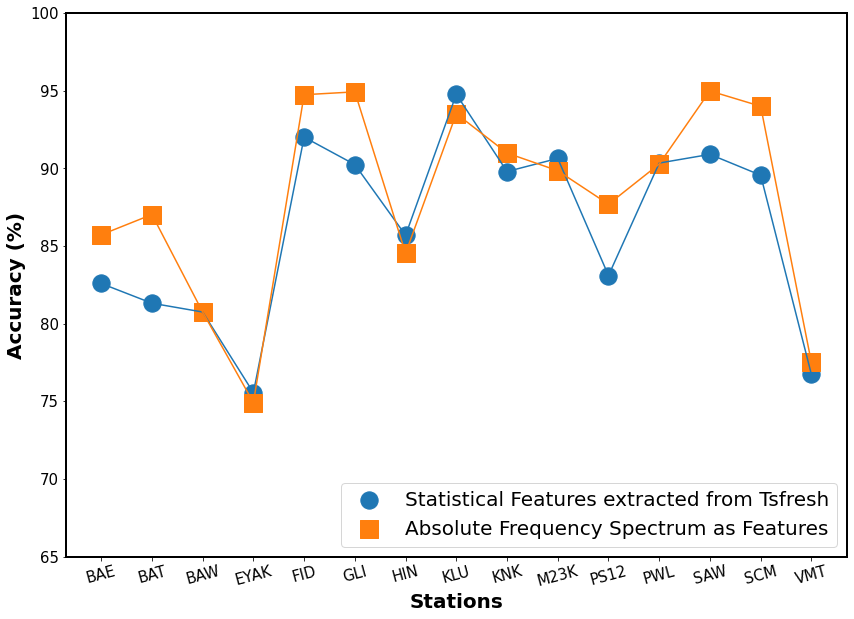

In [229]:
plt.rcParams['axes.linewidth'] = 2
fig, ax = plt.subplots(1,1,figsize=[14,10])
x = np.arange(15)

ax.tick_params(axis='both', which='major', labelsize=15)
ax.scatter(x, np.array(acc_tsfresh)[:,0]*100, s=300, label='Statistical Features extracted from Tsfresh')
ax.plot(x, np.array(acc_tsfresh)[:,0]*100)

ax.scatter(x, np.array(acc_spectrum)[:,0]*100, s=300, marker='s', label='Absolute Frequency Spectrum as Features')
ax.plot(x, np.array(acc_spectrum)[:,0]*100)


ax.set_ylim(65, 100)
ax.set_xlabel('Stations', fontsize=20, weight='bold')
ax.set_ylabel('Accuracy (%)', fontsize=20, weight='bold')
ax.set_xticks(x)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xticklabels(labels=stations, rotation=15, size=15)
ax.legend(loc = 'lower right', ncol=1, fontsize=20)

In [237]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, y, test_size = 0.30, random_state = 101)
forest = RandomForestClassifier(random_state=0)
forest.fit(X_Train, Y_Train)

RandomForestClassifier(random_state=0)

In [239]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]

In [241]:
start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.026 seconds


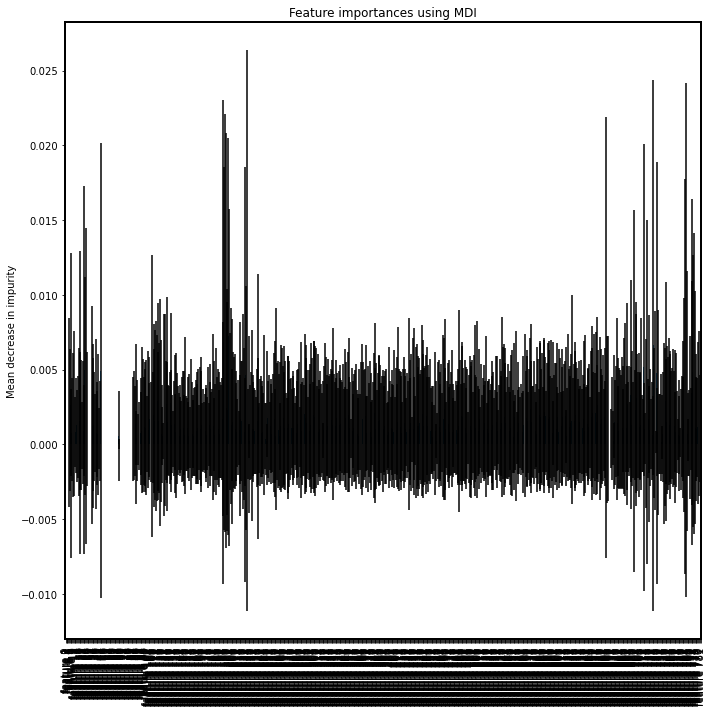

In [243]:
import pandas as pd

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=[10,10])
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

<BarContainer object of 782 artists>

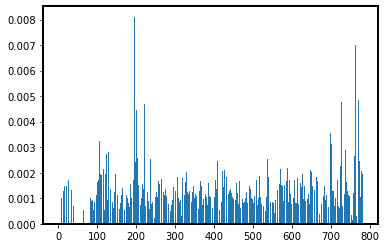

In [248]:
plt.bar(x = range(782),height=importances)

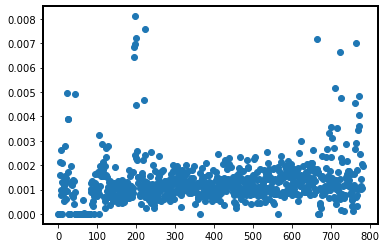

In [245]:
plt.scatter(range(782), importances)

In [164]:
np.shape(X)

(955, 783)

In [176]:
def remove_nan(X):
    first_ind = np.where(np.isnan(X))[0]
    second_ind = np.where(np.isnan(X))[1]
    
    for i in first_ind:
        for j in second_ind: 
            np.delete(X,[i,j])
            
            
    return X

In [182]:
np.reshape(X[~np.isnan(X)],[955,int(np.shape(X[~np.isnan(X)])[0]/955)])

array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          2.46801651e+00,   3.67519962e+00,   1.36613627e+03],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          2.73037378e+00,   3.88265999e+00,   5.65217097e+02],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          3.11934575e+00,   4.77317552e+00,   1.23755110e+03],
       ..., 
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          2.09420155e+00,   3.60372829e+00,   8.03019932e+02],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          2.09063929e+00,   4.15190111e+00,   1.50947234e+03],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          3.46133313e+00,   5.17605446e+00,   1.12589155e+03]])

In [199]:
for i in range(len(np.where(np.isnan(X))[1])):
        if np.where(np.isnan(X))[1][i] != 775:
            print(np.where(np.isnan(X))[1][i])

91
92
93
94
95
96
97
98
99
100
666
667
674
675
676
677
678
91
92
93
94
95
96
97
98
99
100
666
667
674
675
676
677
678
91
92
93
94
95
96
97
98
99
100
666
667
674
675
676
677
678
91
92
93
94
95
96
97
98
99
100
666
667
674
675
676
677
678


In [197]:
len(np.where(np.isnan(X))[0])

5374

In [198]:
len(y)

5306

(65.0, 100.0)

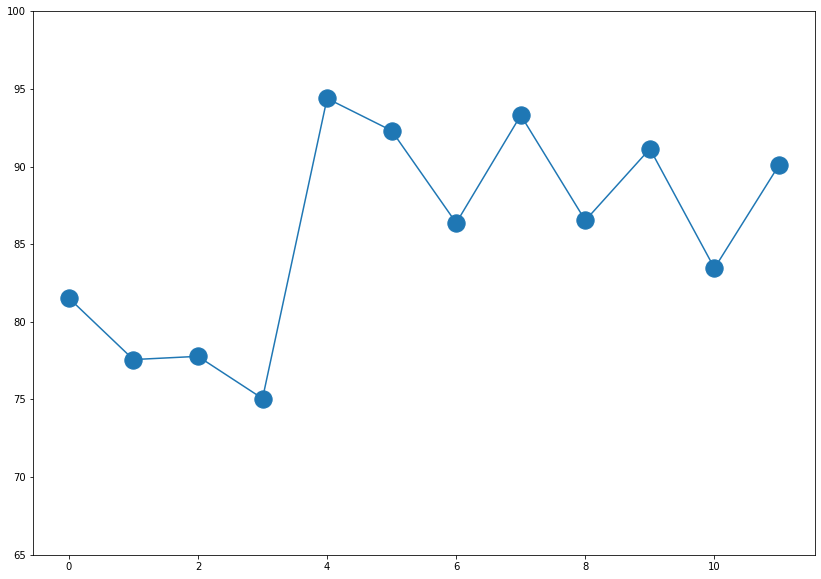

In [134]:
fig, ax = plt.subplots(1,1,figsize=[14,10])
x = np.arange(12)
ax.scatter(x, np.array(acc_stats)[:,0]*100, s=300)
ax.plot(x, np.array(acc_stats)[:,0]*100)
ax.set_ylim(65, 100)

In [71]:
np.shape(X)

(5484, 3000)

In [72]:
df = pd.DataFrame(X.transpose())

df['time'] = st[0].times()
df['id'] = np.zeros([np.shape(X)[1],1])
#df['id'] = np.concatenate((np.zeros([500]),np.ones([500])))
df

,0,1,2,3,4,5,6,7,8,9,...,5476,5477,5478,5479,5480,5481,5482,5483,time,id
0,670.436551,2929.022890,596.583125,393.303866,706.278997,364.189093,511.660848,400.754697,1361.963769,-367.427516,...,39.215159,1089.262483,2344.481665,700.086528,278.244858,2930.722480,55.272272,664.870068,0.0,0.0
1,648.593298,2955.969075,557.464087,412.327200,652.368741,330.825281,433.526434,391.696164,1412.124807,-382.650426,...,-20.323952,906.772684,2335.287258,739.345953,998.055807,2941.340346,94.433985,217.350330,0.1,0.0
2,662.007863,2954.240923,565.469664,378.526718,676.014683,337.390410,455.825035,387.419854,1390.632132,-378.516520,...,-6.250618,940.658171,2351.347875,703.794923,949.254536,2944.936260,80.392895,346.403429,0.2,0.0
3,661.802066,2961.749707,556.013913,357.527120,673.642406,333.286531,448.756651,376.565909,1387.320826,-382.760794,...,-9.753401,904.492999,2359.514218,672.092358,1140.331135,2950.462198,82.980714,292.369600,0.3,0.0
4,674.045701,2965.637986,558.564246,329.145315,689.224337,337.825688,468.858682,366.835551,1364.956035,-383.869806,...,5.843221,911.988198,2375.592659,626.300269,1204.596156,2947.691266,69.229438,349.983817,0.4,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,836.620418,2846.528079,557.419101,300.938004,783.195134,537.525875,559.785514,393.504081,1274.546032,-336.982117,...,94.526407,1349.944628,2333.944956,351.676045,-681.796361,2889.086411,2.823356,1211.737506,299.5,0.0
2996,805.144262,2861.952209,565.341283,319.781727,777.119172,523.526953,559.613363,399.366049,1276.226819,-340.337178,...,91.666701,1345.147723,2341.537739,428.145853,-611.412969,2900.187724,11.712238,1203.693223,299.6,0.0
2997,762.472231,2873.419810,586.294174,325.344359,785.324293,501.659696,577.207563,404.906579,1272.094585,-342.194484,...,105.016018,1351.646447,2356.534862,488.965704,-672.654597,2910.599348,9.589449,1272.781863,299.7,0.0
2998,710.675105,2886.959832,598.591565,336.085337,778.329527,468.987751,576.763497,407.263471,1283.540428,-346.779707,...,104.916960,1328.078965,2363.269378,556.326743,-542.460544,2917.081436,17.438039,1214.663960,299.8,0.0


In [73]:
from tsfresh import extract_features

In [74]:
from tsfresh.feature_extraction import EfficientFCParameters, MinimalFCParameters
df_features = extract_features(df,column_id = "id",column_sort="time", default_fc_parameters = EfficientFCParameters())

Feature Extraction: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [24:14<00:00, 18.18s/it]


In [54]:
df

,0,1,2,3,4,5,6,7,8,9,...,192,193,194,195,196,197,198,199,time,id
0,651,2942,562,424,659,339,449,395,1410,-375,...,2189,-444,844,-617,-1329,23,3788,105,0.00,0.0
1,650,2953,566,420,658,336,447,396,1407,-375,...,2189,-447,831,-617,-1324,22,3769,107,0.02,0.0
2,649,2946,566,415,660,338,448,393,1405,-381,...,2190,-450,817,-618,-1320,20,3789,110,0.04,0.0
3,653,2947,558,416,660,335,446,393,1407,-380,...,2192,-452,800,-624,-1315,16,3793,115,0.06,0.0
4,655,2954,565,413,658,336,446,396,1405,-383,...,2194,-454,783,-622,-1312,12,3785,117,0.08,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,655,2944,774,240,787,273,636,312,1317,-368,...,2221,-500,867,-621,-1219,-59,3736,336,7.90,1.0
396,648,2944,766,234,789,271,633,314,1316,-361,...,2220,-498,882,-622,-1219,-54,3726,328,7.92,1.0
397,644,2944,769,228,790,265,627,314,1312,-357,...,2217,-491,895,-622,-1215,-57,3740,320,7.94,1.0
398,642,2949,767,222,790,260,620,315,1317,-361,...,2213,-488,906,-626,-1214,-57,3735,315,7.96,1.0


In [33]:
st[0].times()

array([  0.00000000e+00,   2.00000000e-02,   4.00000000e-02, ...,
         2.99940000e+02,   2.99960000e+02,   2.99980000e+02])

In [75]:
df_features

,0__variance_larger_than_standard_deviation,0__has_duplicate_max,0__has_duplicate_min,0__has_duplicate,0__sum_values,0__abs_energy,0__mean_abs_change,0__mean_change,0__mean_second_derivative_central,0__median,...,5450__permutation_entropy__dimension_6__tau_1,5450__permutation_entropy__dimension_7__tau_1,5450__query_similarity_count__query_None__threshold_0.0,"5450__matrix_profile__feature_""min""__threshold_0.98","5450__matrix_profile__feature_""max""__threshold_0.98","5450__matrix_profile__feature_""mean""__threshold_0.98","5450__matrix_profile__feature_""median""__threshold_0.98","5450__matrix_profile__feature_""25""__threshold_0.98","5450__matrix_profile__feature_""75""__threshold_0.98",5450__mean_n_absolute_max__number_of_maxima_7
0.0,1.0,0.0,0.0,0.0,2117799.2,1.609762e+09,30.74892,0.006429,0.000148,707.418622,...,2.558344,3.020931,NaN,2.441114,8.645996,4.763013,4.514386,3.843965,5.466248,914.043615


In [76]:
features = df_features.copy()

In [81]:
Home
See new Tweets
Akash Kharita (He/Him)

Your Home Timeline
Towards Data Science
@TDataScience
·
32s
The 
new_features 

,variable,value
0,0__variance_larger_than_standard_deviation,1.000000e+00
1,0__has_duplicate_max,0.000000e+00
2,0__has_duplicate_min,0.000000e+00
3,0__has_duplicate,0.000000e+00
4,0__sum_values,2.117799e+06
...,...,...
4293967,"5450__matrix_profile__feature_""mean""__threshol...",4.763013e+00
4293968,"5450__matrix_profile__feature_""median""__thresh...",4.514386e+00
4293969,"5450__matrix_profile__feature_""25""__threshold_...",3.843965e+00
4293970,"5450__matrix_profile__feature_""75""__threshold_...",5.466248e+00


In [93]:
Variables = new_features['variable'][0:783].values
X_features = new_features['value'].values

In [94]:
Variables

array(['0__variance_larger_than_standard_deviation',
       '0__has_duplicate_max', '0__has_duplicate_min', '0__has_duplicate',
       '0__sum_values', '0__abs_energy', '0__mean_abs_change',
       '0__mean_change', '0__mean_second_derivative_central', '0__median',
       '0__mean', '0__length', '0__standard_deviation',
       '0__variation_coefficient', '0__variance', '0__skewness',
       '0__kurtosis', '0__root_mean_square', '0__absolute_sum_of_changes',
       '0__longest_strike_below_mean', '0__longest_strike_above_mean',
       '0__count_above_mean', '0__count_below_mean',
       '0__last_location_of_maximum', '0__first_location_of_maximum',
       '0__last_location_of_minimum', '0__first_location_of_minimum',
       '0__percentage_of_reoccurring_values_to_all_values',
       '0__percentage_of_reoccurring_datapoints_to_all_datapoints',
       '0__sum_of_reoccurring_values', '0__sum_of_reoccurring_data_points',
       '0__ratio_value_number_to_time_series_length', '0__maximum',
  

In [100]:
X_input = np.reshape(X_features, [np.shape(X)[0],783])

In [102]:
def forest_test(X, Y, n_estimators= 50):
    X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, 
                                                        test_size = 0.30, 
                                                        random_state = 101)
    #X_train_fs, X_test_fs, fs = select_features(X_Train, Y_Train, X_Test)
    
    start = time.process_time()
    trainedforest = RandomForestClassifier(n_estimators=n_estimators).fit(X_Train,Y_Train)
    dur = time.process_time() - start
    predictionforest = trainedforest.predict(X_Test)
    #print(confusion_matrix(Y_Test,predictionforest))
    #print(classification_report(Y_Test,predictionforest))
    acc = accuracy_score(Y_Test, predictionforest)
    
    return acc, dur

In [103]:
forest_test(X_input,y)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [106]:
np.where(np.isnan(X_input))

(array([   0,    1,    2, ..., 5481, 5482, 5483]),
 array([775, 775, 775, ..., 775, 775, 775]))

In [111]:
X_input[0, 773]

3.144168427534737

In [114]:
new = np.delete(X_input, [775], axis=1)

In [118]:
forest_test(new,y)

(0.89854191980558928, 4.565602967000018)

In [136]:
new

array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          2.94969249e+00,   3.95427543e+00,   1.05808608e+03],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          3.90706287e+00,   5.76219582e+00,   7.85998689e+02],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          2.41613939e+00,   4.11166618e+00,   6.84010979e+02],
       ..., 
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          3.35090306e+00,   5.02432459e+00,   7.69675637e+02],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          2.95520089e+00,   5.44087342e+00,   3.68718117e+03],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          2.45324820e+00,   3.51089453e+00,   6.34925796e+02]])

In [138]:
file = open("/home/aakash/Desktop/Reference_Papers/Icequakes_Vs_Tectonicquakes/tsfresh_features/SCM.txt","w+")
file.write(str(new))
file.close()


In [139]:
file = open("/home/aakash/Desktop/Reference_Papers/Icequakes_Vs_Tectonicquakes/tsfresh_features/SCM.txt","r")
content = file.read()

In [143]:
np.array(content)

array('[[  1.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   2.94969249e+00\n    3.95427543e+00   1.05808608e+03]\n [  1.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   3.90706287e+00\n    5.76219582e+00   7.85998689e+02]\n [  1.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   2.41613939e+00\n    4.11166618e+00   6.84010979e+02]\n ..., \n [  1.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   3.35090306e+00\n    5.02432459e+00   7.69675637e+02]\n [  1.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   2.95520089e+00\n    5.44087342e+00   3.68718117e+03]\n [  1.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   2.45324820e+00\n    3.51089453e+00   6.34925796e+02]]',
      dtype='<U679')

In [144]:
np.savetxt("/home/aakash/Desktop/Reference_Papers/Icequakes_Vs_Tectonicquakes/tsfresh_features/SCM.txt", new)

In [145]:
content = np.loadtxt("/home/aakash/Desktop/Reference_Papers/Icequakes_Vs_Tectonicquakes/tsfresh_features/SCM.txt")

In [146]:
content

array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          2.94969249e+00,   3.95427543e+00,   1.05808608e+03],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          3.90706287e+00,   5.76219582e+00,   7.85998689e+02],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          2.41613939e+00,   4.11166618e+00,   6.84010979e+02],
       ..., 
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          3.35090306e+00,   5.02432459e+00,   7.69675637e+02],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          2.95520089e+00,   5.44087342e+00,   3.68718117e+03],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          2.45324820e+00,   3.51089453e+00,   6.34925796e+02]])